<a href="https://colab.research.google.com/github/Adeyinka-hub/MY-MACHINE-LEARNING-AND-DEEP-LEARNING-WORKS-ON-KAGGLE-AND-ZINDI-RESPECTIVELY/blob/master/KAGGLE-Google%20Cloud%20%26%20NCAA%C2%AE%20ML%20Competition%202020%20NCAAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NCAAM2020: XGBoost + LightGBM K-Fold Ensemble (Baseline)

Added XGBoost and K-fold ensemble


## Import Library & Load Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import gc

In [ ]:
tourney_result = pd.read_csv('MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('MNCAATourneySeeds.csv')

In [ ]:
# deleting unnecessary columns
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325
...,...,...,...
2246,2019,1120,1246
2247,2019,1277,1181
2248,2019,1403,1277
2249,2019,1438,1120


## Merge Seed

In [ ]:
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,X09,X08
1,1985,1120,1345,Z11,Z06
2,1985,1207,1250,W01,W16
3,1985,1229,1425,Y09,Y08
4,1985,1242,1325,Z03,Z14
...,...,...,...,...,...
2246,2019,1120,1246,Y05,Y02
2247,2019,1277,1181,W02,W01
2248,2019,1403,1277,X03,W02
2249,2019,1438,1120,Z01,Y05


In [ ]:
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14
...,...,...,...,...,...
2246,2019,1120,1246,5,2
2247,2019,1277,1181,2,1
2248,2019,1403,1277,3,2
2249,2019,1438,1120,1,5


## Merge Score

In [ ]:
season_result = pd.read_csv('MRegularSeasonCompactResults.csv')

In [ ]:
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_result

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Season,TeamID,Score
0,1985,1228,81
1,1985,1106,77
2,1985,1112,63
3,1985,1165,70
4,1985,1192,86
...,...,...,...
323099,2019,1222,57
323100,2019,1426,64
323101,2019,1276,60
323102,2019,1382,53


In [ ]:
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_score

,Season,TeamID,Score
0,1985,1102,1514
1,1985,1103,1404
2,1985,1104,2055
3,1985,1106,1719
4,1985,1108,2075
...,...,...,...
11236,2019,1462,2372
11237,2019,1463,2265
11238,2019,1464,2205
11239,2019,1465,1962


In [ ]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreT,LScoreT
0,1985,1116,1234,9,8,2156,2092
1,1985,1120,1345,11,6,2040,1728
2,1985,1207,1250,1,16,2045,1907
3,1985,1229,1425,9,8,1933,1915
4,1985,1242,1325,3,14,2281,1824
...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,2682,2532
2247,2019,1277,1181,2,1,2680,2839
2248,2019,1403,1277,3,2,2339,2680
2249,2019,1438,1120,1,5,2299,2682


In [ ]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)
tourney_win_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,9,8,2156,2092
1,11,6,2040,1728
2,1,16,2045,1907
3,9,8,1933,1915
4,3,14,2281,1824
...,...,...,...,...
2246,5,2,2682,2532
2247,2,1,2680,2839
2248,3,2,2339,2680
2249,1,5,2299,2682


In [ ]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']
tourney_lose_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,8,9,2092,2156
1,6,11,1728,2040
2,16,1,1907,2045
3,8,9,1915,1933
4,14,3,1824,2281
...,...,...,...,...
2246,2,5,2532,2682
2247,1,2,2839,2680
2248,2,3,2680,2339
2249,5,1,2682,2299


## Prepare Training Data


In [ ]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [ ]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1
...,...,...,...,...,...,...,...
4497,2,5,2532,2682,-3,-150,0
4498,1,2,2839,2680,-1,159,0
4499,2,3,2680,2339,-1,341,0
4500,5,1,2682,2299,4,383,0


## Preparing testing data

In [ ]:
test_df = pd.read_csv('MSampleSubmissionStage1_2020.csv')

In [ ]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [ ]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df

,ID,Pred,Season,WTeamID,LTeamID,Seed1,Seed2,ScoreT1,ScoreT2
0,2015_1107_1112,0.5,2015,1107,1112,W14,Z02,2096,2599
1,2015_1107_1116,0.5,2015,1107,1116,W14,Z05,2096,2653
2,2015_1107_1124,0.5,2015,1107,1124,W14,Z03,2096,2212
3,2015_1107_1125,0.5,2015,1107,1125,W14,W15,2096,2287
4,2015_1107_1129,0.5,2015,1107,1129,W14,W11a,2096,2166
...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,Y09,Y07,2374,2436
11386,2019_1449_1463,0.5,2019,1449,1463,Y09,W14,2374,2265
11387,2019_1458_1459,0.5,2019,1458,1459,Z05,Y07,2279,2436
11388,2019_1458_1463,0.5,2019,1458,1463,Z05,W14,2279,2265


In [ ]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70
...,...,...,...,...,...,...
11385,9,7,2374,2436,2,-62
11386,9,14,2374,2265,-5,109
11387,5,7,2279,2436,-2,-157
11388,5,14,2279,2265,-9,14


## Train

In [ ]:
X = tourney_result.drop('result', axis=1)
y = tourney_result.result

In [ ]:
print(X.head(5))

   Seed1  Seed2  ScoreT1  ScoreT2  Seed_diff  ScoreT_diff
0      9      8     2156     2092          1           64
1     11      6     2040     1728          5          312
2      1     16     2045     1907        -15          138
3      9      8     1933     1915          1           18
4      3     14     2281     1824        -11          457


In [ ]:
print(y.head(5))

0    1
1    1
2    1
3    1
4    1
Name: result, dtype: int64


## Model Training & Evaluation

In [ ]:
params_lgb = {'num_leaves': 127,
          'min_data_in_leaf': 10,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": 0
          }

params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.0003,
              'max_depth': 31,
              'subsample': 1,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':5000,
              'verbosity':0
              }

## LightGBM Predictions

In [ ]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds_lgb = np.zeros(test_df.shape[0])
y_oof_lgb = np.zeros(X.shape[0])
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    y_pred_valid = clf.predict(X_valid)
    y_oof_lgb[valid_index] = y_pred_valid
    
    y_preds_lgb += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

## XGBoost Predictions

In [ ]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)

y_preds_xgb = np.zeros(test_df.shape[0])
y_oof_xgb = np.zeros(X.shape[0])
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_df)
    
    clf = xgb.train(params_xgb, train_set,num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], early_stopping_rounds=100, verbose_eval=100)
    
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.693041	val-logloss:0.693111
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683003	val-logloss:0.689221
[200]	train-logloss:0.673347	val-logloss:0.685578
[300]	train-logloss:0.664118	val-logloss:0.682486
[400]	train-logloss:0.655302	val-logloss:0.679463
[500]	train-logloss:0.646809	val-logloss:0.676709
[600]	train-logloss:0.638558	val-logloss:0.674285
[700]	train-logloss:0.630688	val-logloss:0.671955
[800]	train-logloss:0.623119	val-logloss:0.669905
[900]	train-logloss:0.615844	val-logloss:0.667806
[1000]	train-logloss:0.608794	val-logloss:0.66579
[1100]	train-logloss:0.60201	val-logloss:0.664107
[1200]	train-logloss:0.595387	val-logloss:0.662636
[1300]	train-logloss:0.589055	val-logloss:0.66146
[1400]	train-logloss:0.582861	val-logloss:0.660163
[1500]	train-logloss:0.576901	val-logloss:0.659074
[1600]	train-logloss:0.571145	val-logloss:0.658114


In [ ]:
print(len(y_preds_xgb))
print(len(y_preds_lgb))

11390
11390


In [ ]:
y_preds_lgb

array([3.29577662e-08, 1.16014673e-01, 4.85232890e-02, ...,
       8.76580631e-01, 9.99998620e-01, 9.99963638e-01])

In [ ]:
y_preds_xgb

array([0.26607831, 0.33561751, 0.33847123, ..., 0.48385309, 0.66929468,
       0.66133489])

## Ensemble & Make Submission File

In [ ]:
submission_df = pd.read_csv('MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = 0.9*y_preds_lgb + 0.1*y_preds_xgb
submission_df

,ID,Pred
0,2015_1107_1112,0.026608
1,2015_1107_1116,0.137975
2,2015_1107_1124,0.077518
3,2015_1107_1125,0.874002
4,2015_1107_1129,0.065811
...,...,...
11385,2019_1449_1459,0.230242
11386,2019_1449_1463,0.965715
11387,2019_1458_1459,0.837308
11388,2019_1458_1463,0.966928


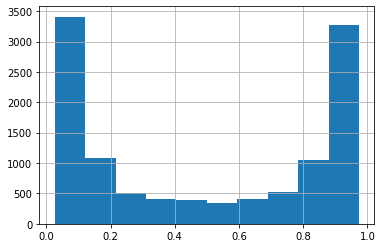

In [ ]:
submission_df['Pred'].hist()

In [ ]:
submission_df.to_csv('submission.csv', index=False)

## Future Work:(Alternative Method to use)

1. GridSearchCV (since this runs considerably fast)

2. CatBoost

3. LSTM

4. Ensembles of XGBoost, LightGBM, CatBoost, LSTM

5. Ensemble weights by correlations